In [1]:
!pip install PyAV

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.1/27.1 MB 44.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
import sys

drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/dads-7202-final-project')

Mounted at /content/drive


In [3]:
import os
import torch
from torch import nn
from torchvision.io import read_video
from torchvision.datasets import VisionDataset
from torch.utils.data import DataLoader
from torchvision.models.video import swin3d_t,Swin3D_T_Weights
import pandas as pd
import numpy as np
from sklearn.metrics import  accuracy_score,precision_score,recall_score,f1_score,average_precision_score
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import gc
import random

In [4]:
# fix seed
# torch.manual_seed(12)
# random.seed(12)
# np.random.seed(12)

In [5]:
class CustomVidDataset(VisionDataset):
    def __init__(self, annotations_file, vid_dir, transform= None, target_transform=None):
        self.vid_labels = pd.read_csv(annotations_file)
        self.vid_dir = vid_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.vid_labels)

    def __getitem__(self, idx):

        vid_path = os.path.join(self.vid_dir, self.vid_labels.iloc[idx, 1])
        vid,_,_ = read_video(vid_path,pts_unit='sec',end_pts=10.0,output_format='TCHW')
        label = self.vid_labels.iloc[idx, 6:18]
        array_label = label.to_numpy()
        array_label = array_label.astype(int)
        trans_vid = vid[::len(vid)//16] # slice frame
        trans_vid = trans_vid[:16]
        if self.transform:
            trans_vid = self.transform(trans_vid)
        if self.target_transform:
            label = self.target_transform(array_label)
        return trans_vid, array_label

In [6]:
#Create Transform for preprocessing
transforms_swin = Swin3D_T_Weights.KINETICS400_V1.transforms()

In [7]:
#Custom Dataset by Transform (Preprocess)
PATH = '/content/drive/MyDrive/dads-7202-final-project/'

train_data_swin = CustomVidDataset(PATH + 'data/train_label.csv', PATH + 'data/train', transform=transforms_swin)
valid_data_swin = CustomVidDataset(PATH + 'data/validate_label.csv', PATH + 'data/validate', transform=transforms_swin)
test_data_swin = CustomVidDataset(PATH + 'data/test_label.csv', PATH + 'data/test', transform=transforms_swin)

In [8]:
#Create Data Loader

batch_size = 32
worker = 4

train_dataset_swin = DataLoader(
    train_data_swin,
    batch_size=batch_size,
    shuffle=True,
    num_workers=worker
)

valid_dataset_swin = DataLoader(
    valid_data_swin,
    batch_size=batch_size,
    shuffle=True,
    num_workers=worker
)

test_dataset_swin = DataLoader(
    test_data_swin,
    batch_size=batch_size,
    shuffle=True,
    num_workers=worker
)

In [9]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [10]:
#Set up Model
model_swin = swin3d_t(weights="KINETICS400_V1")
for param in model_swin.parameters():
    param.requires_grad = False

for param in model_swin.features[6].parameters():
    param.requires_grad = True

model_swin.head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(768,12),
            nn.Sigmoid()
        )
# print(model_swin)

Downloading: "https://download.pytorch.org/models/swin3d_t-7615ae03.pth" to /root/.cache/torch/hub/checkpoints/swin3d_t-7615ae03.pth
100%|██████████| 122M/122M [00:00<00:00, 129MB/s]


In [11]:
model_swin = model_swin.to(device)

In [12]:
#Create Loss Function and Optimizer
loss_fn = nn.BCELoss()
optimizer_swin = torch.optim.Adam(model_swin.parameters(), lr=1e-3)

In [13]:
def scoring(y_true,prediction):

    acc = accuracy_score(y_true,prediction)

    f1s = f1_score(y_true,prediction,average = 'samples', zero_division=0)

    rec_s = recall_score(y_true,prediction,average = 'samples', zero_division=0)

    preci_s = precision_score(y_true,prediction,average = 'samples', zero_division=0)

    ap_s = average_precision_score(y_true,prediction,average = 'samples')
    return acc,f1s,rec_s,preci_s,ap_s

In [14]:
def train(train_dataset,valid_dataset, model, loss_fn, optimizer):

    num_label = 12
    class_label = list(range(num_label))
    label_binarizer = MultiLabelBinarizer(classes=class_label)

    model.train()

    train_loss = 0.
    valid_loss = 0.
    train_y_true_lst = []
    train_y_pred_lst = []

    valid_y_true_lst = []
    valid_y_pred_lst = []

    for data in train_dataset:
        # print(torch.cuda.memory_summary(device=None, abbreviated=False))
        X, y = data
        X, y = X.to(device), y.to(device)

        #  clear the grad
        optimizer.zero_grad()

        # predict
        pred = model(X)
        # compute loss
        loss = loss_fn(pred, y.float())

        # Backpropagation
        loss.backward()
        # update new weight
        optimizer.step()

        round_pred = np.round(pred.detach().cpu())

        train_loss += loss.item()*X.size(0)
        train_y_true_lst.append(y.cpu())
        train_y_pred_lst.append(round_pred)

        # delete locals
        del X
        del y
        del loss
        del pred

        # clean the cache
        if device == "cuda":
            torch.cuda.empty_cache()
        elif device == "mps":
            torch.mps.empty_cache()
        # collect the garbage
        gc.collect()

    # evaluation
    model.eval()
    for data in valid_dataset:
        X, y = data
        X, y = X.to(device), y.to(device)
        # predict
        pred = model(X)
        # compute loss
        loss = loss_fn(pred, y.float())

        round_pred = np.round(pred.detach().cpu())

        valid_loss += loss.item()*X.size(0)
        valid_y_true_lst.append(y.cpu())
        valid_y_pred_lst.append(round_pred)

        # delete locals
        del X
        del y
        del loss
        del pred

        # clean the cache
        if device == "cuda":
            torch.cuda.empty_cache()
        elif device == "mps":
            torch.mps.empty_cache()
        # collect the garbage
        gc.collect()

    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataset.sampler)
    valid_loss = valid_loss/len(valid_dataset.sampler)

    train_y_pred = torch.cat(train_y_pred_lst, dim=0).numpy()
    train_y_pred = label_binarizer.fit_transform(train_y_pred)

    train_y_true = torch.cat(train_y_true_lst, dim=0).numpy()
    train_y_true = label_binarizer.fit_transform(train_y_true)

    valid_y_pred = torch.cat(valid_y_pred_lst, dim=0).numpy()
    valid_y_pred = label_binarizer.fit_transform(valid_y_pred)

    valid_y_true = torch.cat(valid_y_true_lst, dim=0).numpy()
    valid_y_true = label_binarizer.fit_transform(valid_y_true)

    t_acc,t_f1s,t_rec_s,t_preci_s,t_ap_s = scoring(train_y_true,train_y_pred)
    v_acc,v_f1s,v_rec_s,v_preci_s,v_ap_s = scoring(valid_y_true,valid_y_pred)
    print(f"AVG Training Loss: {round(train_loss,4)}\nAVG Validation Loss: {round(valid_loss,4)}")
    print(f"*** Training ***\nAccuracy: {round(t_acc,4)}\nF1: {round(t_f1s,4)}\nRecall: {round(t_rec_s,4)}\nPrecision: {round(t_preci_s,4)}\nAP: {round(t_ap_s,4)}")
    print(f"*** Validation ***\nAccuracy: {round(v_acc,4)}\nF1: {round(v_f1s,4)}\nRecall: {round(v_rec_s,4)}\nPrecision: {round(v_preci_s,4)}\nAP: {round(v_ap_s,4)}")
    return train_loss,valid_loss

In [15]:
def test(test_dataset, model, loss_fn):

  num_label = 12
  class_label = list(range(num_label))
  label_binarizer = MultiLabelBinarizer(classes=class_label)

  test_loss = 0.
  test_y_true_lst = []
  test_y_pred_lst = []

  with torch.no_grad():
    model.eval()
    for data in test_dataset:
      X, y = data
      X, y = X.to(device), y.to(device)
      pred = model(X)
      loss = loss_fn(pred, y.float())

      round_pred = np.round(pred.detach().cpu())

      test_loss += loss.item()*X.size(0)
      test_y_true_lst.append(y.cpu())
      test_y_pred_lst.append(round_pred)

    test_loss = test_loss/len(test_dataset.sampler)

    y_pred = torch.cat(test_y_pred_lst, dim=0).numpy()
    y_pred = label_binarizer.fit_transform(y_pred)

    y_true = torch.cat(test_y_true_lst, dim=0).numpy()
    y_true = label_binarizer.fit_transform(y_true)

    acc,f1s,rec_s,preci_s,ap_s = scoring(y_true,y_pred)

    print(f"AVG Test Loss: {round(test_loss,4)}")
    print(f"Accuracy: {round(acc,4)}\nF1: {round(f1s,4)}\nRecall: {round(rec_s,4)}\nPrecision: {round(preci_s,4)}\nAP: {round(ap_s,4)}")
    return test_loss,test_y_true_lst,test_y_pred_lst

In [16]:
all_train_loss = []
all_valid_loss = []
epochs = 10

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, valid_loss = train(train_dataset_swin,valid_dataset_swin, model_swin, loss_fn, optimizer_swin)
    all_train_loss.append(train_loss)
    all_valid_loss.append(valid_loss)
    print("-------------------------------\n")
end.record()
print("Done!")
torch.cuda.synchronize()
time_run = start.elapsed_time(end)
print(f"Elapsed time: {int((time_run/(1000*60)))} mins")

Epoch 1
-------------------------------
AVG Training Loss: 0.2484
AVG Validation Loss: 0.164
*** Training ***
Accuracy: 0.5739
F1: 0.858
Recall: 0.7869
Precision: 1.0
AP: 0.8225
*** Validation ***
Accuracy: 0.675
F1: 0.8917
Recall: 0.8375
Precision: 1.0
AP: 0.8646
-------------------------------

Epoch 2
-------------------------------
AVG Training Loss: 0.1394
AVG Validation Loss: 0.1642
*** Training ***
Accuracy: 0.7814
F1: 0.9271
Recall: 0.8907
Precision: 1.0
AP: 0.9089
*** Validation ***
Accuracy: 0.9
F1: 0.9667
Recall: 0.95
Precision: 1.0
AP: 0.9583
-------------------------------

Epoch 3
-------------------------------
AVG Training Loss: 0.0932
AVG Validation Loss: 0.1624
*** Training ***
Accuracy: 0.8915
F1: 0.9638
Recall: 0.9458
Precision: 1.0
AP: 0.9548
*** Validation ***
Accuracy: 0.825
F1: 0.9417
Recall: 0.9125
Precision: 1.0
AP: 0.9271
-------------------------------

Epoch 4
-------------------------------
AVG Training Loss: 0.0664
AVG Validation Loss: 0.1867
*** Training

In [17]:
#Test Model
test_loss_resnet,test_y_true_lst,test_y_pred_lst = test(test_dataset_swin,model_swin,loss_fn)

AVG Test Loss: 0.2503
Accuracy: 0.9
F1: 0.9667
Recall: 0.95
Precision: 1.0
AP: 0.9583


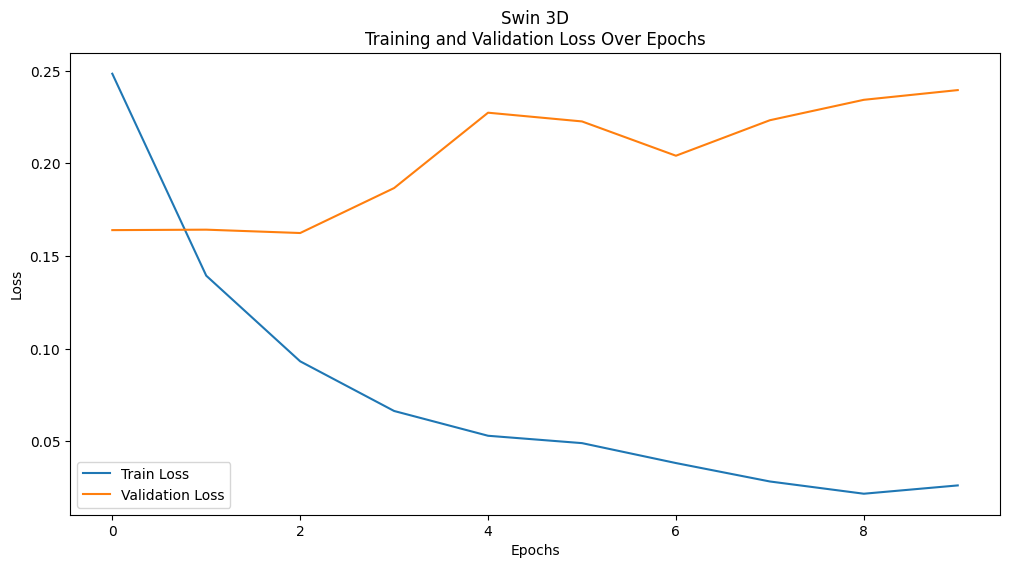

In [18]:
plt.figure(figsize=(12,6))
plt.plot(all_train_loss,label='Train Loss')
plt.plot(all_valid_loss,label='Validation Loss')
plt.legend()
plt.title('Swin 3D\nTraining and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig(PATH +"swin_loss.png",dpi=300)

In [19]:
torch.save(model_swin.state_dict(), PATH+"model_swin.pkl")

In [ ]:
saved_model = swin3d_t(weights="KINETICS400_V1")
for param in saved_model.parameters():
    param.requires_grad = False

for param in saved_model.features[6].parameters():
    param.requires_grad = True

saved_model.head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(768,12),
            nn.Sigmoid()
        )

saved_model.load_state_dict(torch.load(PATH+"model_swin.pkl",map_location=torch.device(device)))
saved_model = saved_model.to(device)

In [ ]:
from google.colab import runtime
runtime.unassign()